In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, auc, roc_curve, average_precision_score, roc_auc_score, precision_recall_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
import ast
from imblearn.over_sampling import SMOTE

sns.set()

Using TensorFlow backend.


## Trying a different model for each stage


We will build a model with the best (smallest p values) for each stage

### Helper functions

In [2]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Get accuracy
    right = np.diagonal(cm).sum()
    acc = float(right)/cm.sum()
    print("Accuracy is {} %".format(acc*100))
    tpr = float(cm[1,1])/cm[1,:].sum()
    fpr = float(cm[0,1])/cm[0,:].sum()
    precision = float(cm[1,1])/cm[:,1].sum()
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return acc, tpr, fpr, precision

# Data preprocessing

In [3]:
df = pd.read_csv('data/cleaned.csv')

In [4]:
genes_p_values = pd.read_csv('data/best_genes_per_stage.csv').drop(columns=['Unnamed: 0'])

In [5]:
def get_genes(r):
    if "nan" in r:
        return None
    t = ast.literal_eval(r)
    return t[0]

def get_pvalue(r):
    if "nan" in r:
        return None
    t = ast.literal_eval(r)
    return t[1]

good_genes_for_1 = genes_p_values['1'].apply(get_genes)
good_genes_for_2 = genes_p_values['2'].apply(get_genes)
good_genes_for_3 = genes_p_values['3'].apply(get_genes)
good_genes_for_4 = genes_p_values['4'].apply(get_genes)

pvalues_for_1 = genes_p_values['1'].apply(get_pvalue)
pvalues_for_2 = genes_p_values['2'].apply(get_pvalue)
pvalues_for_3 = genes_p_values['3'].apply(get_pvalue)
pvalues_for_4 = genes_p_values['4'].apply(get_pvalue)

In [6]:
df['is_stage_1'] = df['tumor_stage'] == 'stage i'
df['is_stage_2'] = df['tumor_stage'] == 'stage ii'
df['is_stage_3'] = df['tumor_stage'] == 'stage iii'
df['is_stage_4'] = df['tumor_stage'] == 'stage iv'

In [7]:
n_of_genes = 30

In [8]:
np.random.seed(2)
test_indices = np.random.choice(df.index, size=200, replace=False)

# Stage 1

In [9]:
X = df[list(good_genes_for_1[:n_of_genes])]
y = df['is_stage_1']

X_train, X_test, y_train, y_test = X[~X.index.isin(test_indices)], X[X.index.isin(test_indices)],\
                                        y[~y.index.isin(test_indices)], y[y.index.isin(test_indices)]
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

## Modeling

#### Tunning

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


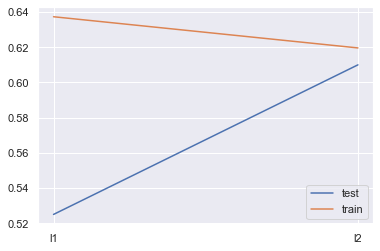

In [14]:
param_values = ['l1', 'l2']
acc_test = []
acc_train = []
for p in param_values:
    clf = LogisticRegression(penalty=p).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_test.append(acc)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    acc_train.append(acc)
plt.plot(param_values, acc_test, label='test')
plt.plot(param_values, acc_train, label='train')
plt.legend()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


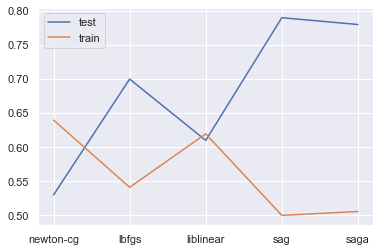

In [15]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
acc_test = []
acc_train = []
for s in solvers:
    clf = LogisticRegression(penalty='l2', solver=s).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_test.append(acc)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    acc_train.append(acc)
plt.plot(solvers, acc_test, label='test')
plt.plot(solvers, acc_train, label='train')
plt.legend()
plt.show()

In [16]:
clf = LogisticRegression(penalty='l2', solver='sag').fit(X_train, y_train)

y_pred = clf.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Results

Accuracy is 73.5 %


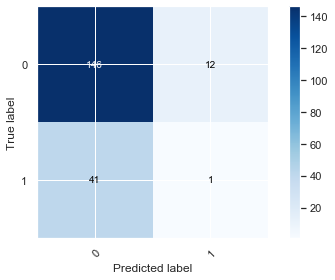

TPR = 0.023809523809523808, FPR = 0.0759493670886076, Precision = 0.07692307692307693


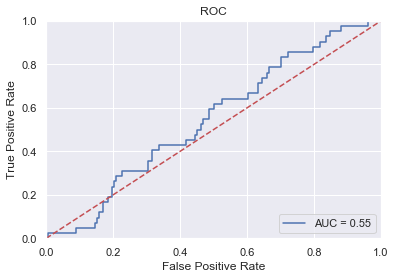

In [17]:
acc, tpr, fpr, precision = plot_confusion_matrix(y_test, y_pred)
plt.show()
print(f"TPR = {tpr}, FPR = {fpr}, Precision = {precision}")

scores = clf.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [248]:
df['is_stage_1'].value_counts()/df.shape[0]

False    0.831579
True     0.168421
Name: is_stage_1, dtype: float64

## Predict proba

In [18]:
proba_1 = clf.predict_proba(X_test)

# Stage 2

In [19]:
X = df[list(good_genes_for_2[:n_of_genes])]
y = df['is_stage_2']

X_train, X_test, y_train, y_test = X[~X.index.isin(test_indices)], X[X.index.isin(test_indices)],\
                                        y[~y.index.isin(test_indices)], y[y.index.isin(test_indices)]
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

## Modeling

#### Tunning

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


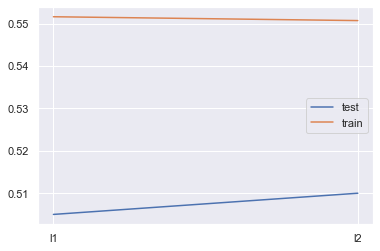

In [20]:
param_values = ['l1', 'l2']
acc_test = []
acc_train = []
for p in param_values:
    clf = LogisticRegression(penalty=p).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_test.append(acc)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    acc_train.append(acc)
plt.plot(param_values, acc_test, label='test')
plt.plot(param_values, acc_train, label='train')
plt.legend()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


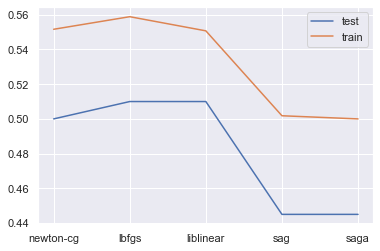

In [21]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
acc_test = []
acc_train = []
for s in solvers:
    clf = LogisticRegression(penalty='l2', solver=s).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_test.append(acc)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    acc_train.append(acc)
plt.plot(solvers, acc_test, label='test')
plt.plot(solvers, acc_train, label='train')
plt.legend()
plt.show()

In [22]:
clf = LogisticRegression(penalty='l2', solver='liblinear').fit(X_train, y_train)
y_pred = clf.predict(X_test)

## Results

Accuracy is 51.0 %


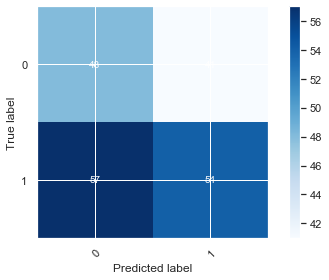

TPR = 0.4864864864864865, FPR = 0.4606741573033708, Precision = 0.5684210526315789


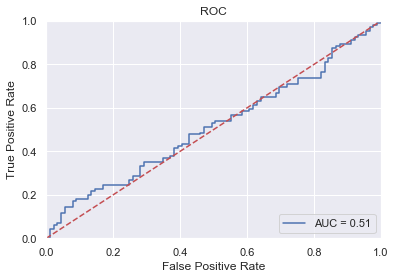

In [23]:
acc, tpr, fpr, precision = plot_confusion_matrix(y_test, y_pred)
plt.show()
print(f"TPR = {tpr}, FPR = {fpr}, Precision = {precision}")

scores = clf.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Predict proba

In [24]:
proba_2 = clf.predict_proba(X_test)

# Stage 3

In [25]:
X = df[list(good_genes_for_3[:n_of_genes])]
y = df['is_stage_3']

X_train, X_test, y_train, y_test = X[~X.index.isin(test_indices)], X[X.index.isin(test_indices)],\
                                        y[~y.index.isin(test_indices)], y[y.index.isin(test_indices)]
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

## Modeling

#### Tunning

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


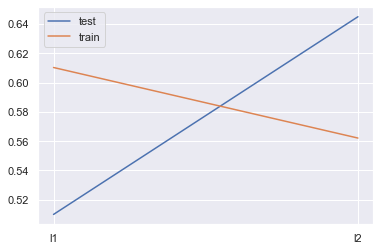

In [26]:
param_values = ['l1', 'l2']
acc_test = []
acc_train = []
for p in param_values:
    clf = LogisticRegression(penalty=p).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_test.append(acc)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    acc_train.append(acc)
plt.plot(param_values, acc_test, label='test')
plt.plot(param_values, acc_train, label='train')
plt.legend()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


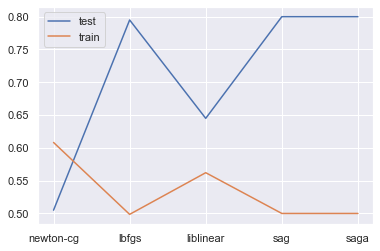

In [27]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
acc_test = []
acc_train = []
for s in solvers:
    clf = LogisticRegression(penalty='l2', solver=s).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_test.append(acc)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    acc_train.append(acc)
plt.plot(solvers, acc_test, label='test')
plt.plot(solvers, acc_train, label='train')
plt.legend()
plt.show()

In [28]:
clf = LogisticRegression(penalty='l2', solver='lbfgs').fit(X_train, y_train)
y_pred = clf.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## Results

Accuracy is 79.5 %


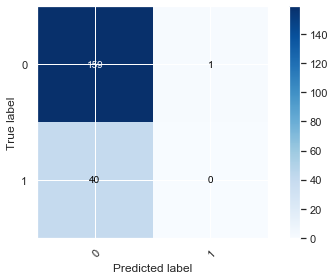

TPR = 0.0, FPR = 0.00625, Precision = 0.0


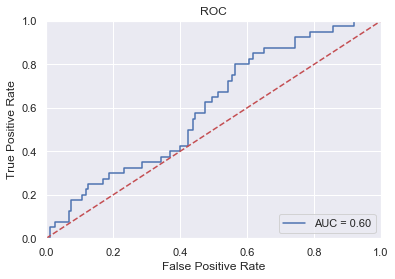

In [29]:
acc, tpr, fpr, precision = plot_confusion_matrix(y_test, y_pred)
plt.show()
print(f"TPR = {tpr}, FPR = {fpr}, Precision = {precision}")

scores = clf.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Predict proba

In [30]:
proba_3 = clf.predict_proba(X_test)

# Stage 4

In [31]:
X = df[list(good_genes_for_4[:n_of_genes])]
y = df['is_stage_4']

X_train, X_test, y_train, y_test = X[~X.index.isin(test_indices)], X[X.index.isin(test_indices)],\
                                        y[~y.index.isin(test_indices)], y[y.index.isin(test_indices)]
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

## Modeling

#### Tunning

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


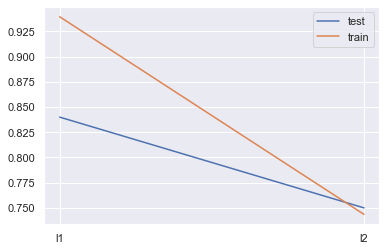

In [32]:
param_values = ['l1', 'l2']
acc_test = []
acc_train = []
for p in param_values:
    clf = LogisticRegression(penalty=p).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_test.append(acc)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    acc_train.append(acc)
plt.plot(param_values, acc_test, label='test')
plt.plot(param_values, acc_train, label='train')
plt.legend()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


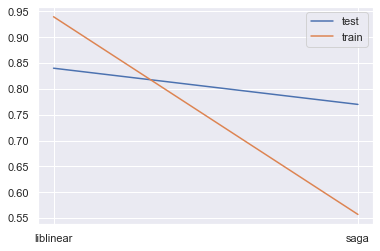

In [38]:
solvers = ['liblinear',  'saga']
acc_test = []
acc_train = []
for s in solvers:
    clf = LogisticRegression(penalty='l1', solver=s).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_test.append(acc)
    y_pred = clf.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    acc_train.append(acc)
plt.plot(solvers, acc_test, label='test')
plt.plot(solvers, acc_train, label='train')
plt.legend()
plt.show()

In [41]:
clf = LogisticRegression(penalty='l1', solver='saga').fit(X_train, y_train)
y_pred = clf.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Results

Accuracy is 77.0 %


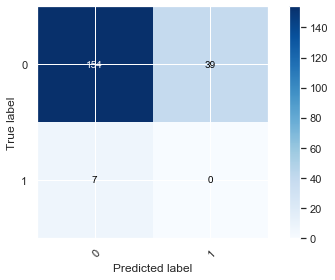

TPR = 0.0, FPR = 0.20207253886010362, Precision = 0.0


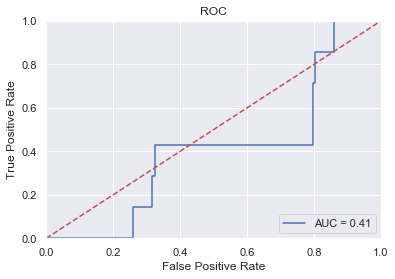

In [42]:
acc, tpr, fpr, precision = plot_confusion_matrix(y_test, y_pred)
plt.show()
print(f"TPR = {tpr}, FPR = {fpr}, Precision = {precision}")

scores = clf.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Predict proba

In [43]:
proba_4 = clf.predict_proba(X_test)

# Combining results

In [276]:
proba_1.shape

(200, 2)

In [44]:
prob_classes = [[p1[1], p2[1], p3[1], p4[1]] for p1, p2, p3, p4 in zip(proba_1, proba_2, proba_3, proba_4)]

In [46]:
y_pred = [np.argmax(row) for row in prob_classes]

In [47]:
y_test = df[df.index.isin(test_indices)]['tumor_stage'].replace({'stage i': 0, 'stage ii': 1, 'stage iii': 2, 'stage iv': 3 })

## Results

Accuracy is 33.0 %


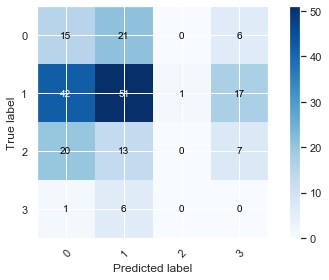

In [48]:
acc, tpr, fpr, precision = plot_confusion_matrix(y_test, y_pred)
plt.show()